In [1]:
%matplotlib inline
from importlib import reload
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_);
import time

from regain.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalIsingModel


from regain import utils; reload(utils);


# ISING

In [2]:
#devo generare dati temporali.. nel dubbio potrei farli tutti uguali, per cominciare
#import regain.datasets.time; reload(regain.datasets.time)
#import regain._datasets.ising; reload(regain._datasets.ising)
import regain.datasets; reload(regain.datasets)
from regain.datasets import make_dataset

samples, thetas = make_dataset(
        n_samples=100, n_dim_obs=10,  T=10,  update_theta='l1',
 distribution='ising', change=2)

l1


In [3]:
import pickle as pkl
with open("../../../../projects/time_exponential_family/data/data_ising_temporal_test_10nodes.pkl", "wb") as f:
    pkl.dump([samples, thetas], f)

In [4]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
from regain.generalized_linear_model.ising import Ising_GLM_GM
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)

from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection

In [ ]:
ising_mdl = Ising_GLM_GM(alpha=0.32, mode='symmetric_fbs', verbose=0)

params = []
estimators = []
for i in range(10):
    cv = GraphicalModelStabilitySelection(ising_mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)},
                                          sampling_size=80,
                                         n_repetitions=20)
    cv.fit(samples[i])
    params.append(cv.best_params_['alpha'])
    estimators.append(cv.best_estimator_)

In [7]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=10)

precisions = []
for train, test in sss.split(samples[0]):
    precs= []
    for i, e in enumerate(estimators):
        e.fit(samples[i][train, :])
        precs.append(e.precision_)
    precisions.append(np.array(precs))

In [8]:
precisions[0].shape

(10, 10, 10)

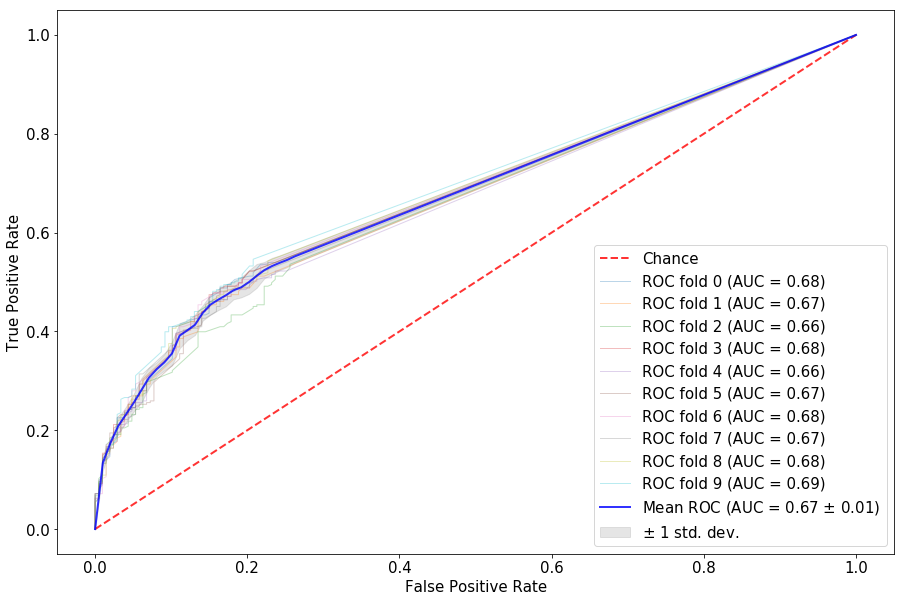

In [12]:
plot_roc_curves(np.array(thetas), [np.abs(p) for p in precisions])

In [460]:
ising_mdl.get_params()

{'alpha': 0.32,
 'compute_objective': True,
 'max_iter': 100,
 'mode': 'symmetric_fbs',
 'reconstruction': 'union',
 'return_history': True,
 'return_n_iter': False,
 'rho': 1,
 'rtol': 0.0001,
 'tol': 0.0001,
 'verbose': 0}

In [8]:
utils.structure_error(np.array(thetas), np.array(precisions), no_diagonal=True)

{'tp': 66,
 'tn': 80,
 'fp': 2,
 'fn': 52,
 'precision': 0.9705882352941176,
 'recall': 0.559322033898305,
 'f1': 0.7096774193548386,
 'accuracy': 0.584,
 'false_omission_rate': 0.3939393939393939,
 'fdr': 0.029411764705882353,
 'npv': 0.6060606060606061,
 'prevalence': 0.472,
 'miss_rate': 0.4406779661016949,
 'fall_out': 0.024390243902439025,
 'specificity': 0.975609756097561,
 'plr': 22.932203389830505,
 'nlr': 0.4516949152542373,
 'dor': 50.76923076923077,
 'balanced_accuracy': 0.7674658949979329,
 'average_precision': 0.9999999999999998}

In [405]:
import pickle as pkl

In [13]:
with open("../../../../projects/time_exponential_family/results_ising/results_single_10nodes.pkl", "wb") as f:
    pkl.dump([precisions, params], f)


In [ ]:
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)
from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection
cv = GraphicalModelStabilitySelection(mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)},
                                      sampling_size=800, plot=True, 
                                      n_repetitions=20)
cv.fit(X, y)

In [15]:
#import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_temporal_linear_model.ising import TemporalIsingModel

from sklearn.gaussian_process import kernels

kernel = kernels.RBF(length_scale=10)(np.arange(10)[:, None])
#kernel = np.ones((10,10))*1
#np.fill_diagonal(kernel, 1)
mdl = TemporalIsingModel(
        alpha=np.mean(params),  psi='l1', assume_centered=True, rtol=1e-5, tol=1e-4,
        max_iter=300, rho=1.,  kernel=kernels.RBF, ker_param='auto',  init='zeros', verbose=0)

X = np.vstack(samples)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(samples)]).flatten().astype(int)
#base_results(mdl, X, y, K, thetas, ells, search_spaces=None)

In [16]:
mdl.fit(X, y)

Find new theta: 9.999995


KeyboardInterrupt: 

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10)

precisions_time = []
for train, test in sss.split(X, y):
    mdl.fit(X[train, :], y[train])
    precisions_time.append(mdl.precision_)

Find new theta: 9.999995
Find new theta: 0.018386
Find new theta: 9.999995
Find new theta: 0.018386
Find new theta: 9.999995
Find new theta: 0.018386
Find new theta: 9.999995
Find new theta: 0.018386
Find new theta: 9.999995
Find new theta: 0.018386
Find new theta: 9.999995
Find new theta: 0.018386
Find new theta: 9.999995
Find new theta: 0.018386
Find new theta: 9.999995
Find new theta: 0.018386
Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018386


In [12]:
utils.structure_error(np.array(thetas), mdl.precision_, no_diagonal=True)

{'tp': 72,
 'tn': 82,
 'fp': 0,
 'fn': 46,
 'precision': 1.0,
 'recall': 0.6101694915254238,
 'f1': 0.7578947368421053,
 'accuracy': 0.616,
 'false_omission_rate': 0.359375,
 'fdr': 0.0,
 'npv': 0.640625,
 'prevalence': 0.472,
 'miss_rate': 0.3898305084745763,
 'fall_out': 0.0,
 'specificity': 1.0,
 'plr': 0,
 'nlr': 0.3898305084745763,
 'dor': 0.0,
 'balanced_accuracy': 0.8050847457627119,
 'average_precision': 0.9999999999999998}

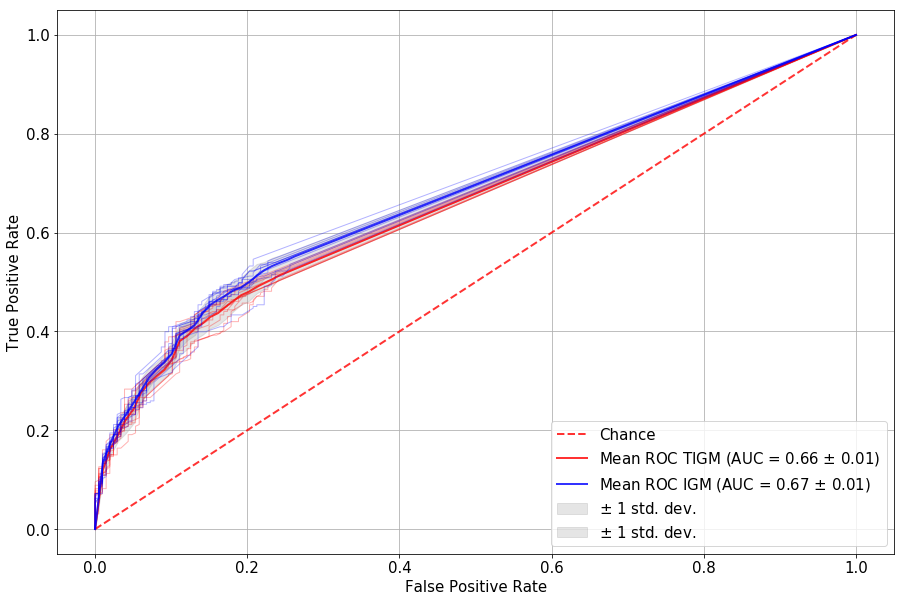

In [18]:
import regain.plotting.results; reload(regain.plotting.results)
from regain.plotting.results import plot_roc_curves, plot_precision_recall_comparison, plot_roc_comparison

plot_roc_comparison(np.abs(np.array(thetas)), {'TIGM':[np.abs(p) for p in precisions_time],
                                                'IGM':[np.abs(p) for p in precisions]})

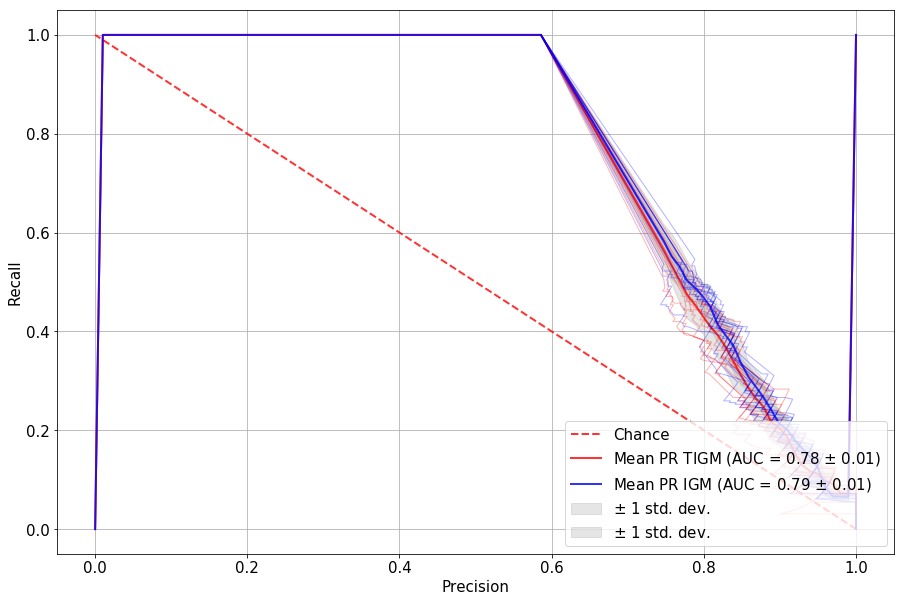

In [19]:
import regain.plotting.results; reload(regain.plotting.results)
from regain.plotting.results import plot_roc_curves, plot_precision_recall_comparison, plot_roc_comparison

plot_precision_recall_comparison(np.abs(np.array(thetas)), {'TIGM':[np.abs(p) for p in precisions_time],
                                                'IGM':[np.abs(p) for p in precisions]})

In [21]:
import regain.utils; reload(regain.utils)
from regain.utils import structure_error, mean_structure_error

In [22]:
mean_structure_error(np.array(thetas), [np.abs(p) for p in precisions])

{'tp': '310.4+/-6.1838499334961226',
 'tn': '220.6+/-6.8731361109758335',
 'fp': '93.4+/-6.8731361109758335',
 'fn': '275.6+/-6.1838499334961226',
 'precision': '0.7688761771619423+/-0.013088039771545545',
 'recall': '0.5296928327645051+/-0.010552644937706702',
 'f1': '0.6271708985634354+/-0.00925625012198217',
 'accuracy': '0.531+/-0.008820430828479987',
 'false_omission_rate': '0.5554616718205486+/-0.009139567085069493',
 'fdr': '0.2311238228380576+/-0.013088039771545532',
 'npv': '0.4445383281794514+/-0.009139567085069503',
 'prevalence': '0.5860000000000001+/-1.1102230246251565e-16',
 'miss_rate': '0.4703071672354949+/-0.010552644937706695',
 'fall_out': '0.29745222929936305+/-0.021888968506292458',
 'specificity': '0.7025477707006369+/-0.021888968506292458',
 'plr': '1.7898467706378494+/-0.12891395432127753',
 'nlr': '0.6700512610875016+/-0.024845425611639133',
 'dor': '2.681504821906702+/-0.28585541678096105',
 'balanced_accuracy': '0.616120301732571+/-0.011712675125357367',
 'av

In [23]:
mean_structure_error(np.array(thetas), [np.abs(p) for p in precisions_time])

{'tp': '283.2+/-8.772684879784524',
 'tn': '233.2+/-10.087616170334794',
 'fp': '80.8+/-10.087616170334794',
 'fn': '302.8+/-8.772684879784524',
 'precision': '0.7787426861354302+/-0.016733849353008787',
 'recall': '0.4832764505119454+/-0.01497045201328416',
 'f1': '0.5960968178440493+/-0.00863804649840577',
 'accuracy': '0.5164+/-0.005986651818838311',
 'false_omission_rate': '0.5650473561864571+/-0.006490602038420603',
 'fdr': '0.22125731386456984+/-0.016733849353008805',
 'npv': '0.4349526438135429+/-0.006490602038420607',
 'prevalence': '0.5860000000000001+/-1.1102230246251565e-16',
 'miss_rate': '0.5167235494880547+/-0.014970452013284176',
 'fall_out': '0.25732484076433126+/-0.03212616614756303',
 'specificity': '0.7426751592356688+/-0.03212616614756307',
 'plr': '1.8992371388004234+/-0.1762702309617667',
 'nlr': '0.6963790978958958+/-0.018353301283496503',
 'dor': '2.7353210611473857+/-0.31982483680864393',
 'balanced_accuracy': '0.6129758048738071+/-0.010951028789945267',
 'aver